In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import random
import math
import scipy.stats
from astropy.time import Time
from collections import Counter
from scipy.stats import lognorm
from scipy.stats import cauchy
from scipy.stats import rayleigh
from scipy.stats import chi2
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import exponpow
from scipy.stats import norm
from scipy.stats import powerlaw
from scipy.stats import uniform

dfO2 = pd.DataFrame()

dfO21 = pd.read_excel('O2_Filter.xlsx', sheet_name = None)
print("x")
dfO21 = pd.concat(pd.read_excel('O2_Filter.xlsx', sheet_name=None), ignore_index=True)
print("x")
dfO21.rename(columns = {'Dec[deg]':'Dec','log10[E/GeV]':'log10','RA[deg]':'RA'}, inplace = True)
print("x")

dfIce10 = pd.read_excel('IceCube_10_years.xlsx')
print("x")
dfIce10 = pd.concat(pd.read_excel('IceCube_10_years.xlsx', sheet_name=None), ignore_index = True)
print("x")
dfIce10.rename(columns = {'MJD[days]':'GPS','Dec[deg]':'Dec','log10(E/GeV)':'log10','RA[deg]':'RA'}, inplace = True)
print("x")

mjd_df = pd.DataFrame(dfIce10['GPS'])
print('x')

times = Time(getattr(mjd_df, 'GPS'), format='mjd')
print('x')
gps_times = {'GPS': times.gps}
print('x')
gps_df = pd.DataFrame(gps_times)
print("x")
dfIce10['GPS'] = gps_df
print("x")

dfO2 = dfO2.append(dfO21, ignore_index = True)
print("x")
dfO2 = dfO2.append(dfIce10, ignore_index = True)
print("x")
#dfO2 = dfO2.loc[dfO2.Dec > -5]

    ##Python was having trouble reading the brackets, so I redefined the column names to have it be better
    ##Redefinition of column names (especially in the original file) is necessary to make sure that all data points have
        #a possibility of being included in the sample
    ##I changed the columns in the original file to be consistent
    ##Chose declinations above -5
    ##Only here for clarity. This specific variable is unused.

x
x
x
x
x
x
x
x
x
x
x
x
x


In [63]:
class Sampler:
    def fitter(count, n, stepSize, ninitial):
        distType = -1
        
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))] 
    
        
        #plotPointsStan = dfO2[dfO2.Dec > (ninitial + stepSize * count)]
        #plotPoints24 = plotPointsStan[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))] 

        f = Fitter(plotPoints24.log10, distributions= get_common_distributions())
        f.fit()

        distInfo = f.get_best(method = 'sumsquare_error')
        
        if 'lognorm' in distInfo:
            distType = 0
            return [distType, distInfo['lognorm']['s'], distInfo['lognorm']['loc'], distInfo['lognorm']['scale']]
        
        elif 'cauchy' in distInfo:
            distType = 1
            return [distType, distInfo['cauchy']['loc'], distInfo['cauchy']['scale']]
        
        elif 'chi2' in distInfo:
            distType = 2
            return [distType, distInfo['chi2']['df'], distInfo['chi2']['loc'], distInfo['chi2']['scale']]
        
        elif 'rayleigh' in distInfo:
            distType = 3
            return [distType, distInfo['rayleigh']['loc'], distInfo['rayleigh']['scale']]
        
        elif 'gamma' in distInfo:
            distType = 4
            return [distType, distInfo['gamma']['a'], distInfo['gamma']['loc'], distInfo['gamma']['scale']]
        
        elif 'expon' in distInfo:
            distType = 5
            return [distType, distInfo['expon']['loc'], distInfo['expon']['scale']]
        
        elif 'exponpow' in distInfo:
            distType = 6
            return [distType, distInfo['exponpow']['b'], distInfo['exponpow']['loc'], distInfo['exponpow']['scale']]
        
        elif 'norm' in distInfo:
            distType = 7
            return [distType, distInfo['norm']['loc'], distInfo['norm']['scale']]
        
        elif 'powerlaw' in distInfo:
            distType = 8
            return [distType, distInfo['powerlaw']['a'], distInfo['powerlaw']['loc'], distInfo['powerlaw']['scale']]
        
        elif 'uniform' in distInfo:
            distType = 9
            return [distType, distInfo['uniform']['loc'], distInfo['uniform']['scale']]
        
        return distType
        
    def flognorm(count, n, stepSize, ninitial, pointNum):
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        setofEl = []
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: lognorm.pdf(x,s=(distPlotInfo[1]), loc=(distPlotInfo[2]), scale=(distPlotInfo[3]))
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2

    def fchi2(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: chi2.pdf(x, df = distPlotInfo[1], loc = distPlotInfo[2], scale = distPlotInfo[3])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        #y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2

    def fcauchy(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: cauchy.pdf(x, loc = distPlotInfo[1], scale = distPlotInfo[2])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)
        
        v = u1[idx]
        y = u2[idx]

        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1 
        
        return x, fx, v, setofEl, u1, u2

    def frayleigh(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))] 
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: rayleigh.pdf(x, loc = distPlotInfo[1], scale = distPlotInfo[2])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)
        
        v = u1[idx]
        y = u2[idx]

        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def fgamma(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: gamma.pdf(x, a = distPlotInfo[1], loc = distPlotInfo[2], scale = distPlotInfo[3])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        #y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def fexpon(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: expon.pdf(x, loc = distPlotInfo[1], scale = distPlotInfo[2])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        #y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def fexponpow(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: exponpow.pdf(x, b = distPlotInfo[1], loc = distPlotInfo[2], scale = distPlotInfo[3])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        #y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def fnorm(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))] 
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: norm.pdf(x, loc = distPlotInfo[1], scale = distPlotInfo[2])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
            ##Use random.randint to select indexes between 0 and end (80,000) 10,000 times
            ##Find the log10 associated with each index selected and save to array
            ##Assign the log10 array as u1
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)
        
        v = u1[idx]
        #y = u2[idx]

        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def fpowerlaw(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: powerlaw.pdf(x, a = distPlotInfo[1], loc = distPlotInfo[2], scale = distPlotInfo[3])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)

        v = u1[idx]
        y = u2[idx]
        
        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1
        
        return x, fx, v, setofEl, u1, u2
    
    def funiform(count, n, stepSize, ninitial, pointNum):
        setofEl = []
        distPlotInfo = Sampler.fitter(count, n, stepSize, ninitial)
        plotPointsStan = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
        plotPoints24 = plotPointsStan.loc[plotPointsStan.Dec < (ninitial + stepSize * (count + 1))]
        x = np.linspace(min(plotPoints24.log10), max(plotPoints24.log10),num=10000,endpoint=True)
        f = lambda x: uniform.pdf(x, loc = distPlotInfo[1], scale = distPlotInfo[2])
        fx = f(x)
        M = 1
        u1 = np.random.rand(10000)*5
        u2 = np.random.rand(10000)*3
        idx,=np.where((u2)<=f(u1)/M)
        
        v = u1[idx]
        y = u2[idx]

        for j in range(pointNum):
            newidx = (random.choice(idx))
            if newidx not in setofEl:
                setofEl.append(newidx)
            else:
                j = j - 1 
        
        return x, fx, v, setofEl, u1, u2

    def plotDevice(count, n, stepSize, ninitial, pointNum):
        dt = Sampler.fitter(count, n, stepSize, ninitial)
        #print(dt)
        if (dt[0] == 0):
            Sampler.flognorm(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.flognorm(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
                      
        elif (dt[0] == 1):
            Sampler.fcauchy(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fcauchy(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)

        elif (dt[0] == 2):
            Sampler.fchi2(count, n, stepSize, ninitial, pointNum)  
            x, fx, v, setofEl, u1, u2 = Sampler.fchi2(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
    
        elif (dt[0] == 3):
            Sampler.frayleigh(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.frayleigh(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)

        elif (dt[0] == 4):
            Sampler.fgamma(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fgamma(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
        elif (dt[0] == 5):
            Sampler.fexpon(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fexpon(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
        elif (dt[0] == 6):
            Sampler.fexponpow(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fexponpow(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
        elif (dt[0] == 7):
            Sampler.fnorm(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fnorm(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
        elif (dt[0] == 8):
            Sampler.fpowerlaw(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fpowerlaw(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
        elif (dt[0] == 9):
            Sampler.funiform(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.funiform(count, n, stepSize, ninitial, pointNum)
            plt.hist(v,bins=40, histtype = 'step', linewidth = 2, alpha = 0.7, density = True)
            plt.xlabel("log10")
            plt.ylabel("f(log10)")
            plt.plot(x,fx)
            
    def sampleSpots(count, n, stepSize, ninitial, pointNum, log10En):
        dt = Sampler.fitter(count, n, stepSize, ninitial)
        if (dt[0] == 0):
            Sampler.flognorm(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.flognorm(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                      
        elif (dt[0] == 1):
            Sampler.fcauchy(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fcauchy(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)

        elif (dt[0] == 2):
            Sampler.fchi2(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fchi2(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)

        elif (dt[0] == 3):
            Sampler.frayleigh(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.frayleigh(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 4):
            Sampler.fgamma(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fgamma(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 5):
            Sampler.fexpon(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fexpon(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 6):
            Sampler.fexponpow(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fexponpow(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 7):
            Sampler.fnorm(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fnorm(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 8):
            Sampler.fpowerlaw(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.fpowerlaw(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
                
        elif (dt[0] == 9):
            Sampler.funiform(count, n, stepSize, ninitial, pointNum)
            x, fx, v, setofEl, u1, u2 = Sampler.funiform(count, n, stepSize, ninitial, pointNum)
            for k in range(len(setofEl)):
                v1 = u1[setofEl[k]]
                y1 = u2[setofEl[k]]
                plt.scatter(v1,y1)
                log10En.append(v1)
            #Chose to use an "elif" statement in lieu of "else" in case more distributions need to be added later
            
    def weightCalc(ninitial, stepSize, binNumber, sampleNum):
        weightCalc = []
        decCount = []
        decList = []
        countNum = 0
        count = 0 
        
        for x in range(binNumber):        
            plotPoints1 = dfO2.loc[dfO2.Dec > (ninitial + stepSize * count)]
            plotPoints2 = plotPoints1.loc[plotPoints1.Dec < (ninitial + stepSize * (count + 1))] 
            
            weightCalc.append(plotPoints2.shape[0]/dfO2.shape[0])
            decCount.append(count)
            count += 1
 
        decTemp = random.choices(decCount, weights = weightCalc, k = sampleNum)
        decAll = Counter(decTemp)
        print("Percentage Calc by Dec:", weightCalc)
        print("")
        print("Weighted Declination Sample:", decTemp)
        print("")
        print(decAll)        
        print("--------------------------")

        for decNum in decAll.keys():
            count = decNum
            #print(decNum)
            print("Declination Bin Number:", decNum, '| Dec Count:', decAll[decNum]) 
            print("Start at", ninitial + stepSize * count, "| End at", ninitial + stepSize * (count + 1))
            decCount = np.random.uniform(ninitial + stepSize * count, ninitial + stepSize * (count + 1), decAll[decNum])
            print(decCount)
            print("")
            countNum += decAll[decNum]
            
            for dec in decCount:
                decList.append(dec)
                
        print('\33[1m' + '\033[38;5;204m' + "All Declinations Selected:" + '\33[0;0m', decList)
        print("")
        print("Total Declination Bins Sampled (out of 10):", len(decAll))
        print("Total Declinations Sampled:", countNum)

Declination Sampling:
Percentage Calc by Dec: [0.12249872592478629, 0.13165283613950401, 0.10418008852819473, 0.08321474016878692, 0.0652847357776346, 0.05161687356366049, 0.03984409806693142, 0.02731969832463116, 0.015469196226814235, 0.0050778708360177055]

Weighted Declination Sample: [3, 2, 4, 9, 4, 4, 8, 4, 6, 5, 1, 3, 6, 6, 3, 3, 2, 1, 5, 4]

Counter({4: 5, 3: 4, 6: 3, 2: 2, 5: 2, 1: 2, 9: 1, 8: 1})
--------------------------
Declination Bin Number: 3 | Dec Count: 4
Start at 23.5 | End at 33.0
[25.77511318 30.82582829 23.6024684  31.25141581]

Declination Bin Number: 2 | Dec Count: 2
Start at 14.0 | End at 23.5
[20.58475035 17.41017022]

Declination Bin Number: 4 | Dec Count: 5
Start at 33.0 | End at 42.5
[41.0161416  37.42402573 34.67681522 33.2780171  38.99503613]

Declination Bin Number: 9 | Dec Count: 1
Start at 80.5 | End at 90.0
[86.80335178]

Declination Bin Number: 8 | Dec Count: 1
Start at 71.0 | End at 80.5
[74.05623691]

Declination Bin Number: 6 | Dec Count: 3
Start a

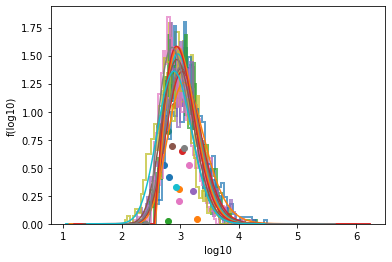

In [69]:
n = -5
    #This is the choice of initial declination; will iterate
nfinal = 90
    #This is the choice of final declination
binNumber = 10
    #This is the choice of number of bins (i.e., distributions) desired
sampleNum = 20
    #This is the choice of MINIMUM total number of points one desires to sample
count = 0
    #Do not change this number
    #Accounts for the declination bin at which the programme is looking
ninitial = n
    #The initial declination number, fixed
stepSize = (nfinal - n)/float(binNumber)
    #The range of a declination bin
pointNum = math.ceil(sampleNum/binNumber)
    #Corresponds to the number of points that will be plotted
    #Note that if the declination number divided by desired sample point number is not an integer,
        #this programme will round up the division and provide more points than the inputted sample number


print('\33[1m' + '\033[38;5;198m' + "Declination Sampling:" + '\33[0;0m')
Sampler.weightCalc(ninitial, stepSize, binNumber, sampleNum)
print("")
print("#####################################################")
print("")

log10En = []
    
for z in range(binNumber):
    Sampler.plotDevice(count, n, stepSize, ninitial, pointNum)
    Sampler.sampleSpots(count, n, stepSize, ninitial, pointNum, log10En)
    n = n + stepSize
    count = count + 1
    z = z + 1
    
rightAsc = np.random.uniform(dfO2['RA'].min(), dfO2['RA'].max(), 20)
#plt.text(3.8, 2.7, 'Right Ascension: ' + str(rightAsc))
print('\33[1m' + '\033[38;5;198m' + "Right Ascension:" + '\33[0;0m', rightAsc) 
print("")
print("#####################################################")
print("")
    
gpsTime = np.random.uniform(dfO2['GPS'].min(), dfO2['GPS'].max(), 20)
print('\33[1m' + '\033[38;5;198m' + "GPS Time:" + '\33[0;0m', gpsTime)
print("")
print("#####################################################")
print("")
    
print('\33[1m' + '\033[38;5;198m' + "Log10 Energy:" + '\33[0;0m', log10En)
print("")

In [4]:
print(dfO2.shape[0])

1247964


In [ ]:
#Actual 1247977
#Ask about where to output / mode to output